In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import config

In [3]:
api_key = config.api_key
channel_ids = ['UCaO6VoaYJv4kS-TQO_M-N_g', 'UCV0qA-eDDICsRR9rPcnG7tw' ]
# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=api_key)

In [4]:
def get_channel_stats(youtube, channel_ids):

    all_data = []

    # request for channel
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop for iterate in each item
    for item in response['items']:
        data = {'channel_name': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'total_videos': item['statistics']['videoCount'],
                'playlist_id': item['contentDetails']['relatedPlaylists']['uploads']  
        }

        all_data.append(data)

    return pd.DataFrame(all_data)

In [5]:
data_channels = get_channel_stats(youtube, channel_ids)
data_channels.head()

,channel_name,subscribers,views,total_videos,playlist_id
0,Joma Tech,2060000,164791621,107,UUV0qA-eDDICsRR9rPcnG7tw
1,Clément Mihailescu,503000,68239625,245,UUaO6VoaYJv4kS-TQO_M-N_g


In [6]:
def get_video_ids(youtube, playlist_id):

    video_ids = []

    #request for playlist
    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            maxResults=50,
            playlistId=playlist_id
            )
    response = request.execute()

    # loop for iterate in each item
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')

    while next_page_token is not None:
        request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                maxResults=50,
                playlistId=playlist_id,
                pageToken = next_page_token
                )
        response = request.execute()   

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')


    return video_ids

In [7]:
def get_video_details(youtube, video_ids):

        all_video_info = []

        for i in range(0, len(video_ids), 50):

                request = youtube.videos().list(
                        part = 'snippet,contentDetails, statistics',
                        id = ','.join(video_ids[i:i+50])
                )
        
                response = request.execute()
                #print(json.dumps(response, indent=3))

                for video in response['items']:
                        stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                                        'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                                        'contentDetails': ['duration', 'definition', 'caption']
                                        }
                        video_info = {}
                        video_info['video_id'] = video['id']

                        for k in stats_to_keep.keys():
                                for v in stats_to_keep[k]:
                                        try:
                                                video_info[v] = video[k][v]
                                        except:
                                                video_info[v] = None

                        all_video_info.append(video_info)

        return pd.DataFrame(all_video_info) 

In [8]:
def get_comments_in_videos(youtube, video_ids):
  
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)    

In [9]:
video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for channel in data_channels['channel_name'].unique(): # I use the unique() method just if a row is repeated in the var data_channels

    print(f"Getting information from channel: {channel}")

    playlist_id = data_channels[data_channels['channel_name']==channel]['playlist_id'].iloc[0]
    print(playlist_id)
    video_ids = get_video_ids(youtube, playlist_id)

    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = pd.concat([video_df, video_data])
    print(len(video_df))
    comments_df = pd.concat([comments_df,comments_data])
    print(len(comments_df))

Getting information from channel: Joma Tech
UUV0qA-eDDICsRR9rPcnG7tw
Could not get comments for video Z0N7vqSgRBY
107
106
Getting information from channel: Clément Mihailescu
UUaO6VoaYJv4kS-TQO_M-N_g
352
351


## data preprocessing

In [31]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [32]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [33]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,XLVEOMGqYBE,Joma Tech,if hollywood made a movie about crypto,A portion of this video is sponsored by Coinba...,"[joma, vlog, coinbase earn, coinbase earn and ...",2022-06-17T15:16:25Z,44263,3341,None,482,PT3M36S,hd,true
1,KHEZCXfyxjU,Joma Tech,if Wolf of Wall Street were about crypto,👾 Join the discord for more updates on the liv...,"[joma, vlog]",2022-04-08T15:00:28Z,1031868,52875,None,3427,PT5M12S,hd,true
2,314OLE6mKOo,Joma Tech,interviewing at a startup be like... (ft. Stev...,Looking for a Software Engineering job? Curren...,"[joma, vlog]",2022-03-10T16:11:21Z,1785953,76533,None,4782,PT8M22S,hd,true
3,JgdP7oWP0_0,Joma Tech,i like the rock...,"If you want to be featured in my videos, you c...","[joma, vlog]",2022-02-19T14:54:12Z,671780,37252,None,1752,PT3M56S,hd,false
4,JwjwnSdI4Yw,Joma Tech,"We raised $234,080 in 30 seconds with NFTs! Th...","Again, thank you so much to everyone who minte...","[joma, vlog]",2022-02-03T00:00:29Z,406035,21424,None,1879,PT1M50S,hd,false


In [34]:
# transform to numeric columns
numeric_cols = ['viewCount', 'likeCount', 'commentCount', 'favouriteCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

# publish day in the week
from dateutil import parser
video_df['publishedAt_timestamp'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishDayName'] = video_df['publishedAt_timestamp'].apply(lambda x: x.strftime("%A"))

# get seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

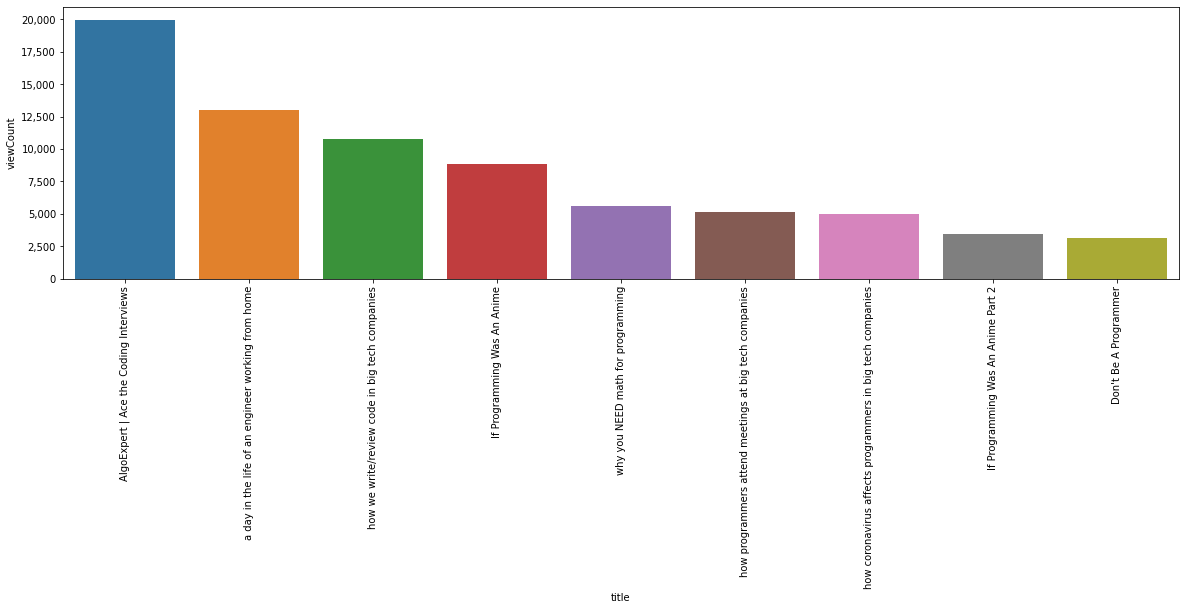

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,5
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) ))


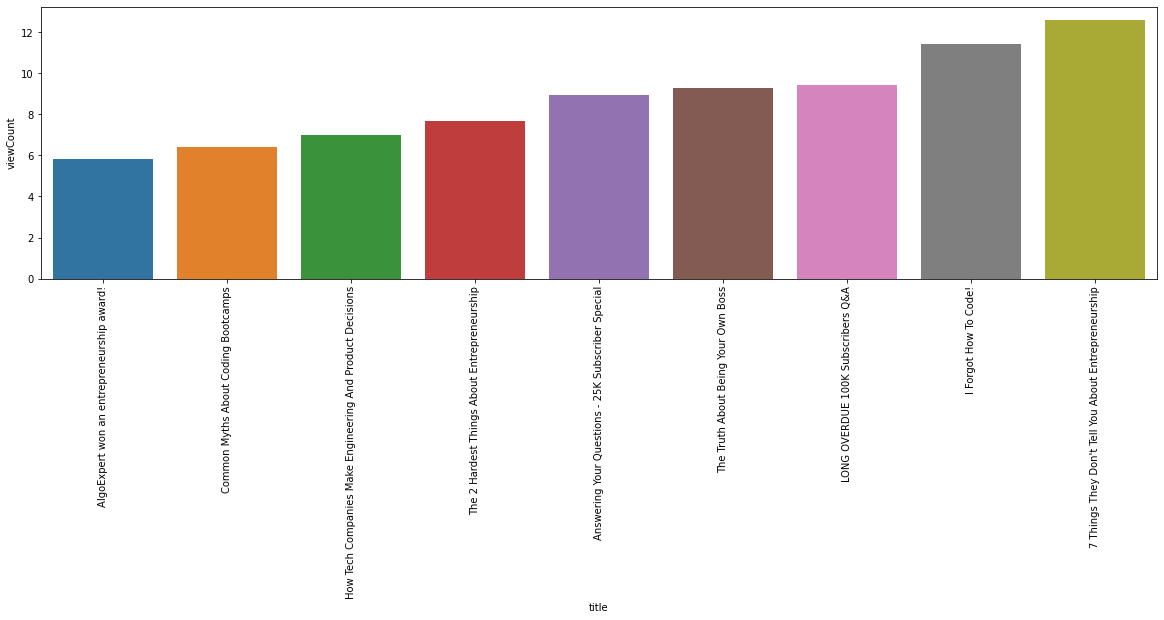

In [36]:
rcParams['figure.figsize'] = 20,5
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) ))


d:\Programming_Platforms\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


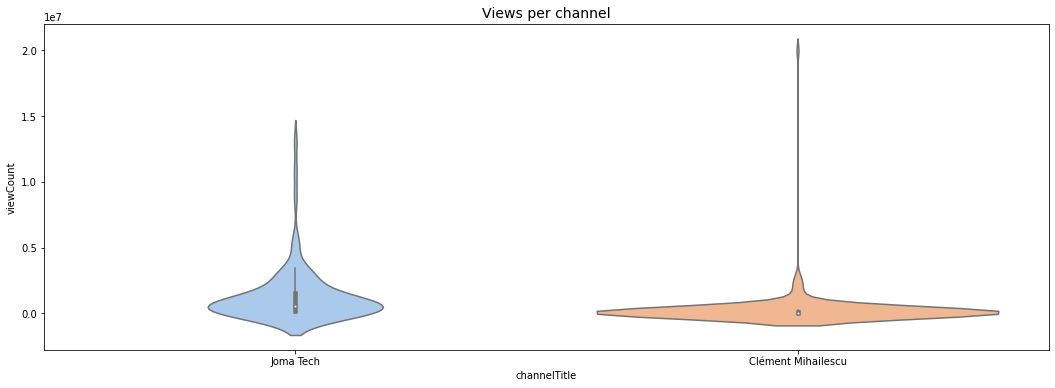

In [38]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

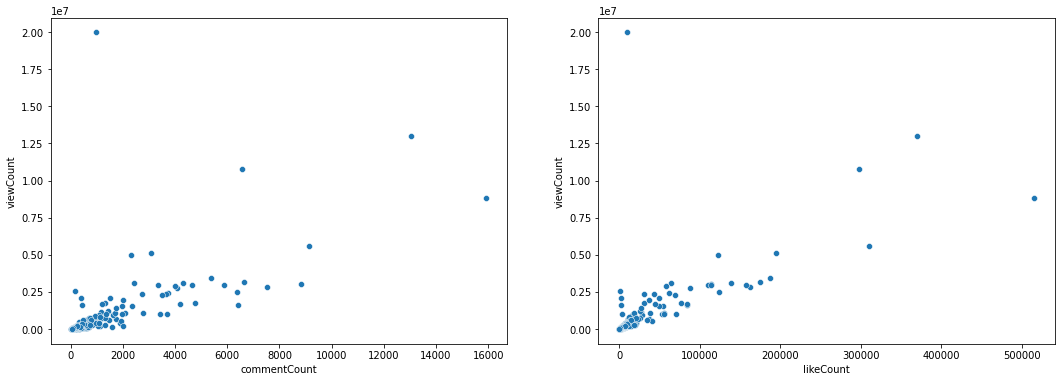

In [39]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

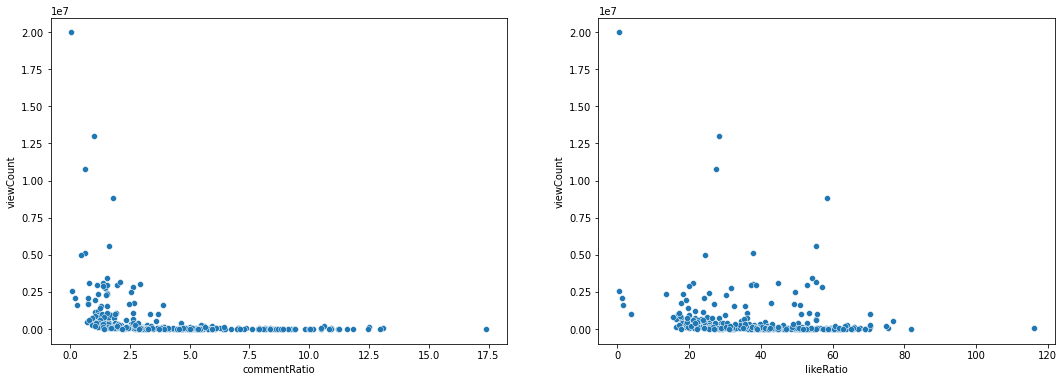

In [40]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

C:\Users\adamo\AppData\Local\Temp\ipykernel_25300\1339236931.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=video_df[video_df['durationSecs'] < 10000].reset_index(drop=True), x="durationSecs", bins=30)


<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

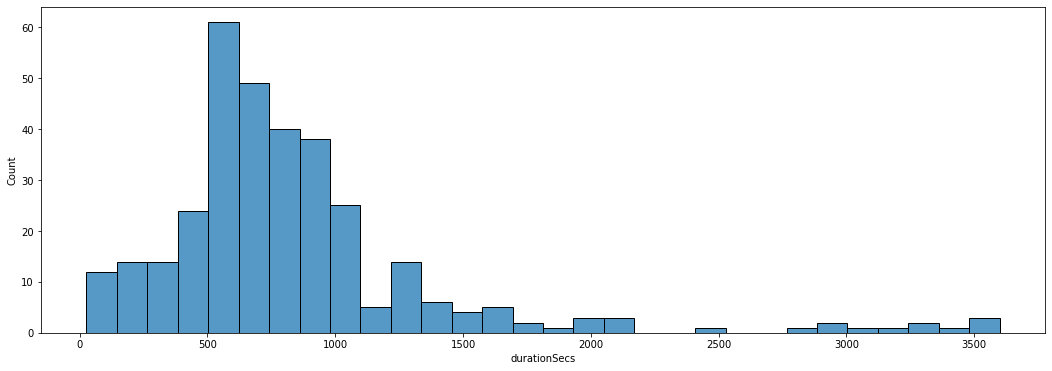

In [92]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000].reset_index(drop=True), x="durationSecs", bins=30)

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

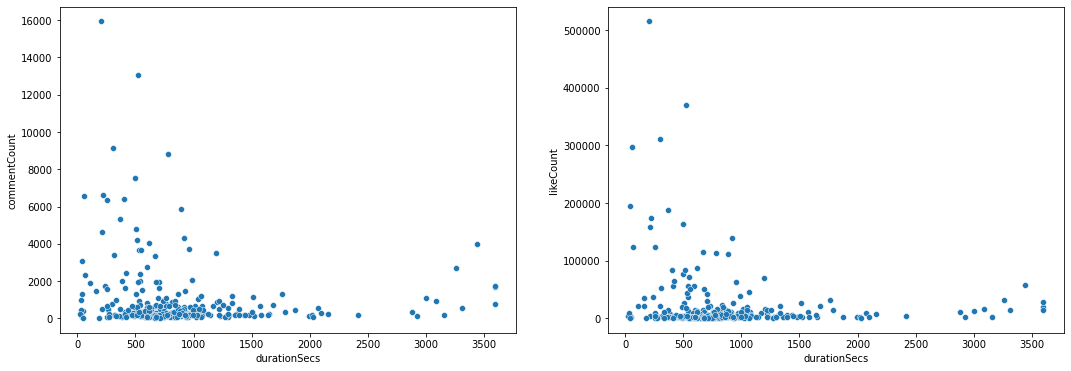

In [48]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

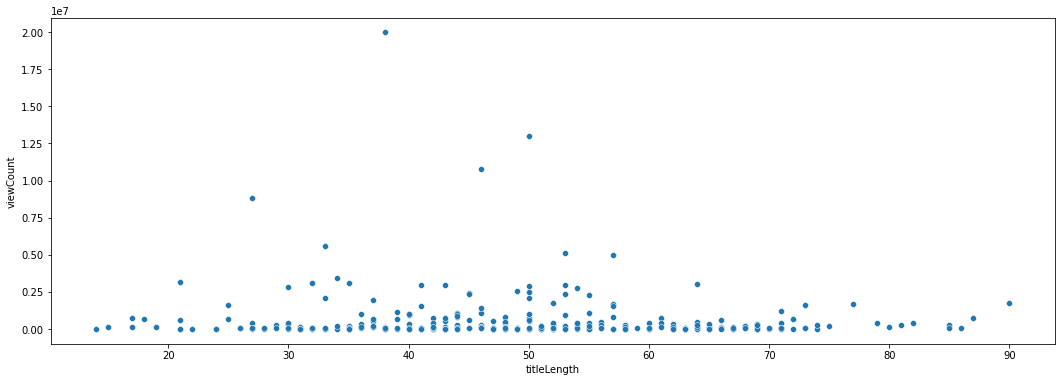

In [42]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adamo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adamo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


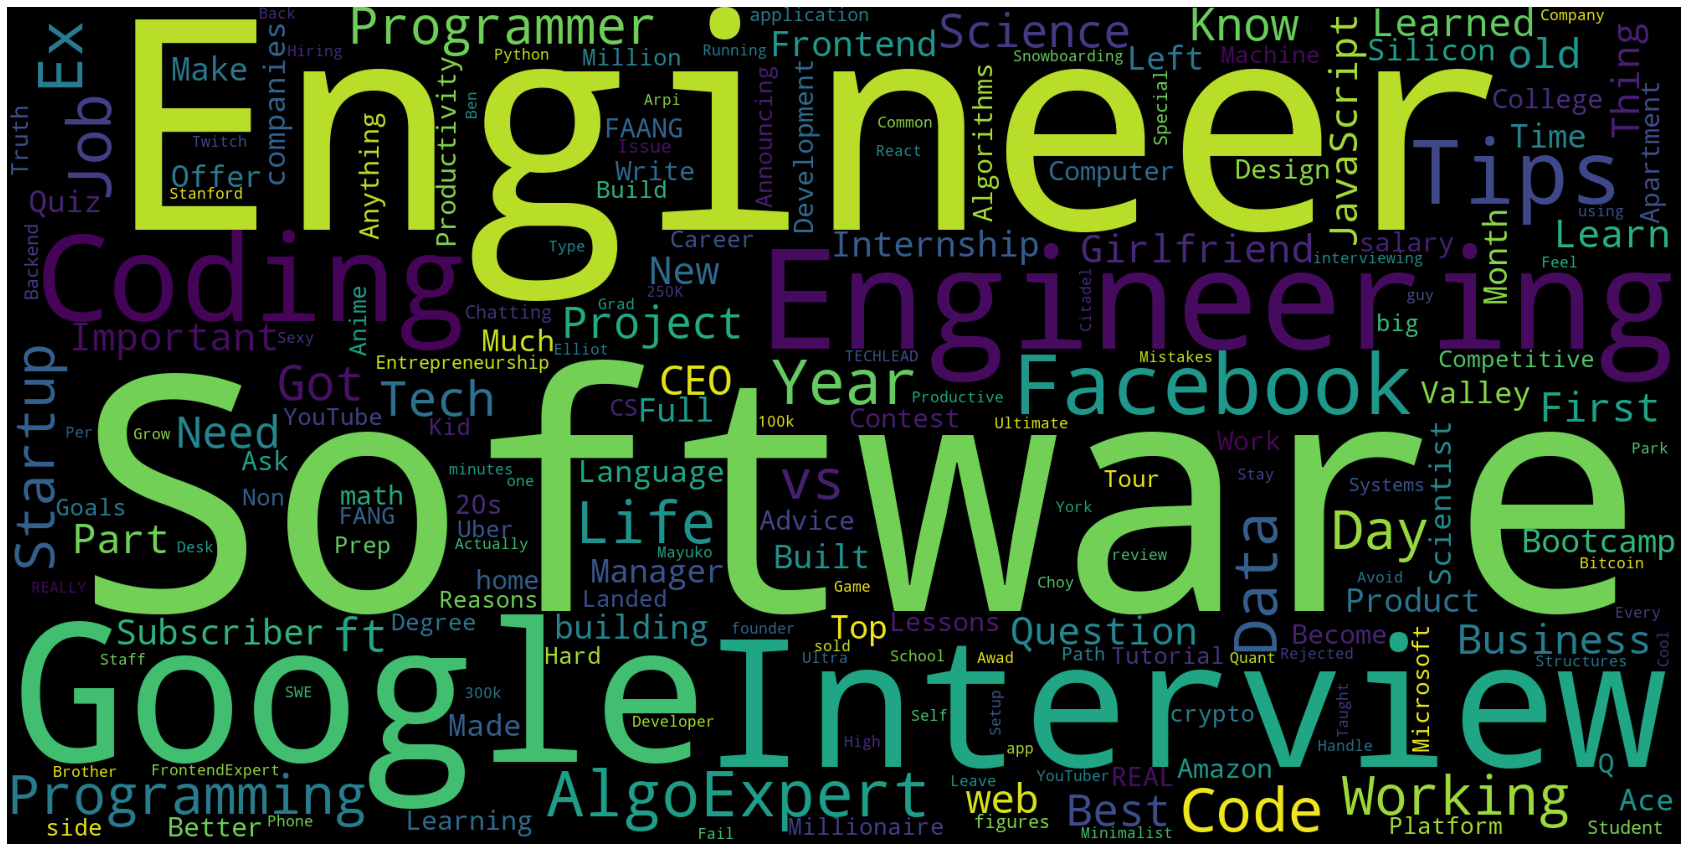

In [43]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

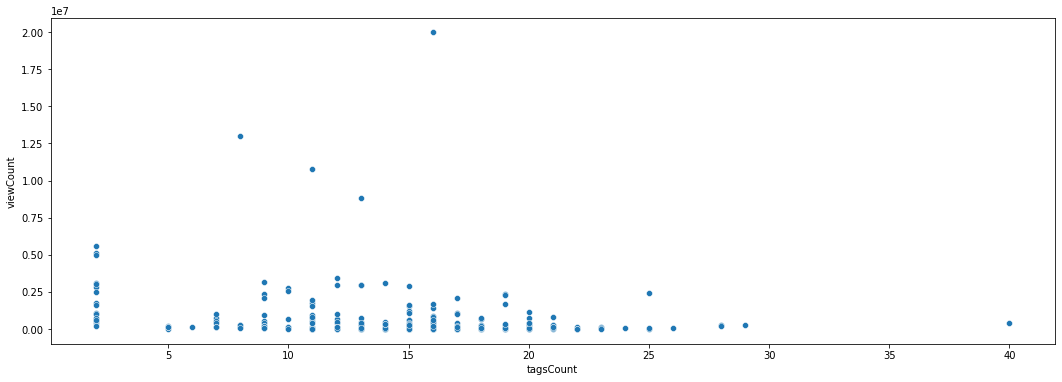

In [44]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

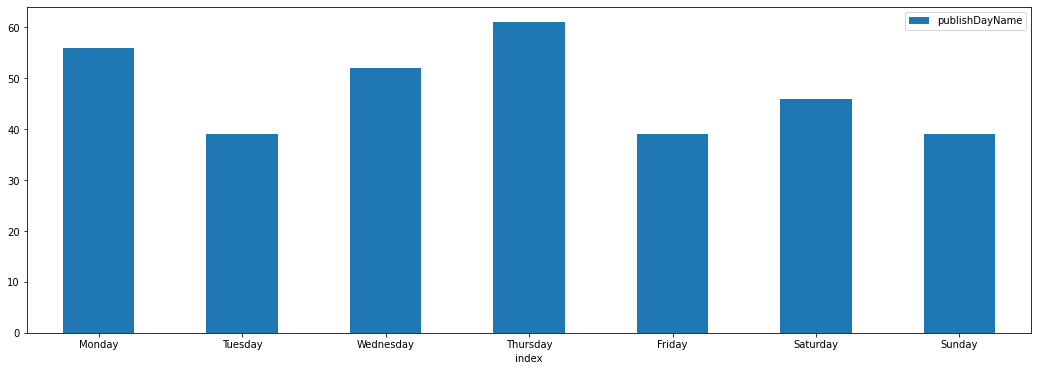

In [45]:

day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)

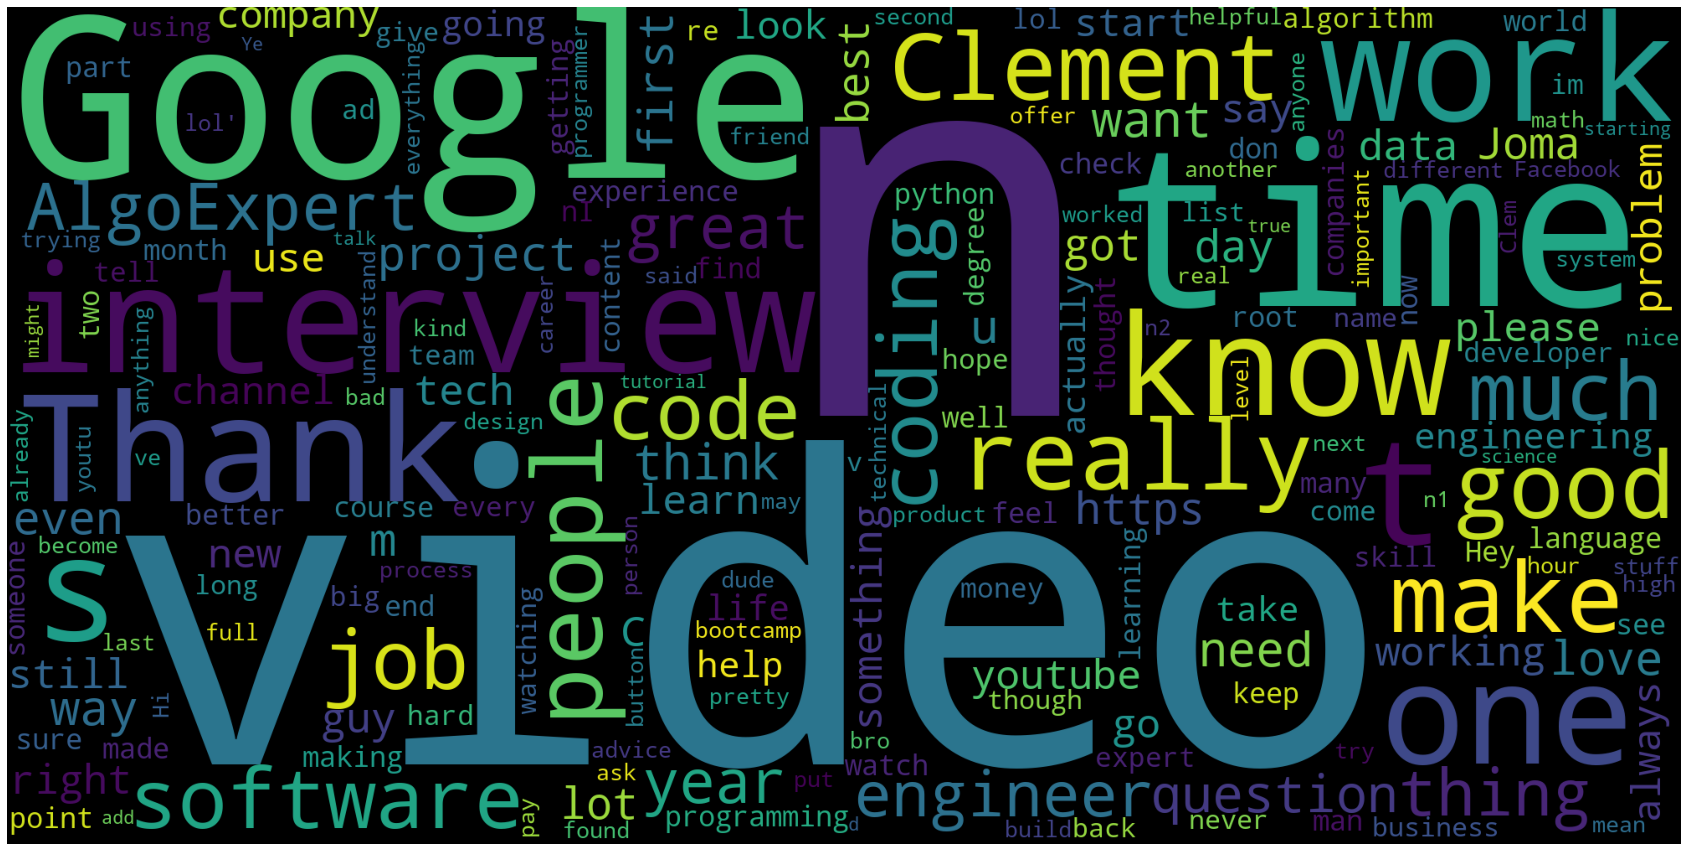

In [46]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)